# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import scipy as spy
import copy
import math
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn import linear_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

---

# Data ingestion 

In [3]:
data = pd.read_csv("dataprep_used_cars_data.csv")

---

# Data Preparation

**Create a clone of the dataset**

In [4]:
df1 = copy.deepcopy(data)

**Dropping unnecessary columns**

In [5]:
df1_cols = df1.columns.to_list()
drop_cols = ['car_name', 'car_make', 'car_model', 'car_spec','location', 'year']
df1.drop(columns=drop_cols, inplace=True)

**Dropping highly correlated columns**

The `engine` and `power` variables were highly positively correlated. In the context of vehicles, the bigger the engine size the more powerful is the vehicle.

Therefore the `power` variable will also be dropped.

In [6]:
df1.drop(columns='power', inplace=True)

**Scaling Mileage based on Mileage units**

To do this we shall create two separate series for the scaled value of either unit then combine both series.

In [7]:
# For "kmpl"
x = df1[df1.mileage_unit == "kmpl"].mileage
x_min = x.min()
x_max = x.max()
df1["kmpl_temp"] = x.apply(lambda x: (x - x_min / (x_max - x_min)))

# For "km/kg"
y = df1[df1.mileage_unit == "km/kg"].mileage
y_min = y.min()
y_max = y.max()
df1["kmkg_temp"] = y.apply(lambda y: (y - y_min / (y_max - y_min)))

# Combining scaled mileage
df1["mileage_scaled"] = df1["kmpl_temp"].combine_first(df1["kmkg_temp"])

# Drop columns "kmpl_temp", "kmkg_temp", "mileage_unit" and "mileage"
df1.drop(["kmpl_temp", "kmkg_temp", "mileage_unit",
         "mileage"], axis=1, inplace=True)

---

Now let consider dealing with the outliers.

Lets **log transform to the numerical variables**.

Note the `seats` and `car_age` are ordinal variables which we shall not do any outlier corrections

In [8]:
# Column to Log transform
log_cols = ["engine", "kilometers_driven", "price",'mileage_scaled']

for col in log_cols:
    df1[col] = np.log(df1[col])

In [9]:
def boxplot_overview(data):
    """
    This function below generates a subplots of `box plots` &
    showing the `distribution of the numerical variable input with outliers`.

    * Generates subplots for each numerical variable in a three column structure.
    * The function takes the Pandas dataframe as the input
    * The function selects the numerical variables from the applied dataframe.
    * It shows the `mean` in the boxplot.
    * `sns.set_style` - sets the Seaborn theme
    * `subplot_nrows` - calculated number of subplot rows
    * `subplot_ncols` - configures the three column structure subplots
    * `figsize` - indicates the size of the plot
    * `sns.reset_defaults()` - resets Seaborn themes and settings to default
    """

    num_vars = data.select_dtypes(include=np.number).columns.to_list()
    plt.figure(figsize=(10, 10))
    for i in range(len(num_vars)):
        # Set seaborn theme
        sns.set_style("darkgrid")
        # Subplot no of columns
        subplot_ncols = math.ceil(np.sqrt(len(num_vars)) )  
        # Subplot no of rows
        subplot_nrows = math.ceil(len(num_vars) / subplot_ncols)  
          
        plt.subplot(subplot_nrows, subplot_ncols, i + 1)
        sns.boxplot(y=data[num_vars[i]], width=0.3, showmeans=True)
        plt.tight_layout()
        plt.title(num_vars[i], fontsize=16)
    plt.show()
    # Reset seaborn theme
    sns.reset_defaults()

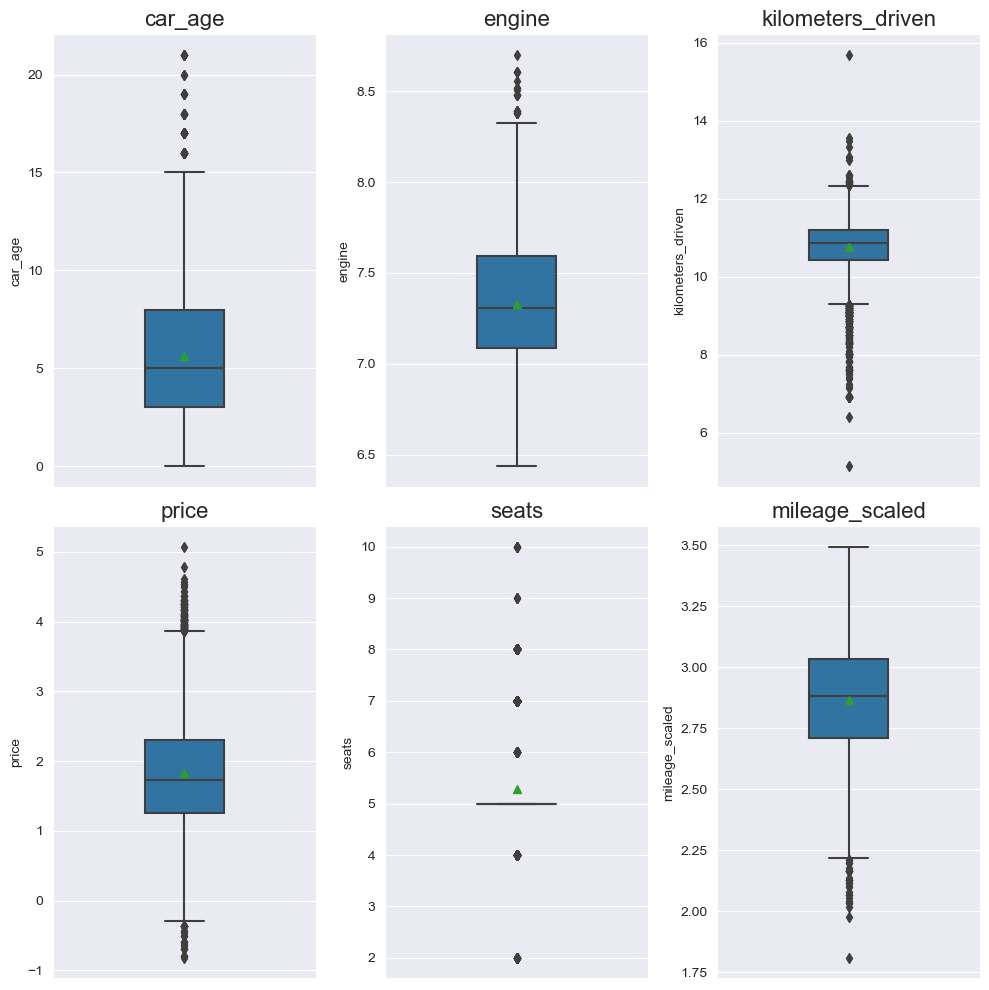

In [10]:
# Check the boxplot overview to see if any outliers still exist
boxplot_overview(df1)

There is still outliers in the log transformed data but lets continue with the evaluation.

## Outlier Treatment

Now let consider dealing with the outliers.

There are different methods to deal with outliers but lets us start with **Data capping/Winsorizing**

Note the `seats` and `car_age` are ordinal variables which we shall not do any outlier corrections

Outlier are values that exist beyond the upper and lower whiskers of the boxplot.

So lets clip outliers to their respective upper and lower whisker.

**Clipping lower and upper numerical outliers to lower and upper whiskers respectively**

In [11]:
# List of numeric variables
numeric = df1.select_dtypes(include=np.number).columns.to_list()
numeric.remove('seats')
numeric.remove('car_age')

In [12]:
for var in numeric:
    Q1 = df1[var].quantile(0.25)  # 25th quantile
    Q3 = df1[var].quantile(0.75)  # 75th quantile
    IQR = Q3-Q1
    Lower_Whisker = Q1 - 1.5*IQR
    Upper_Whisker = Q3 + 1.5*IQR
    df1[var] = np.clip(df1[var], Lower_Whisker, Upper_Whisker)

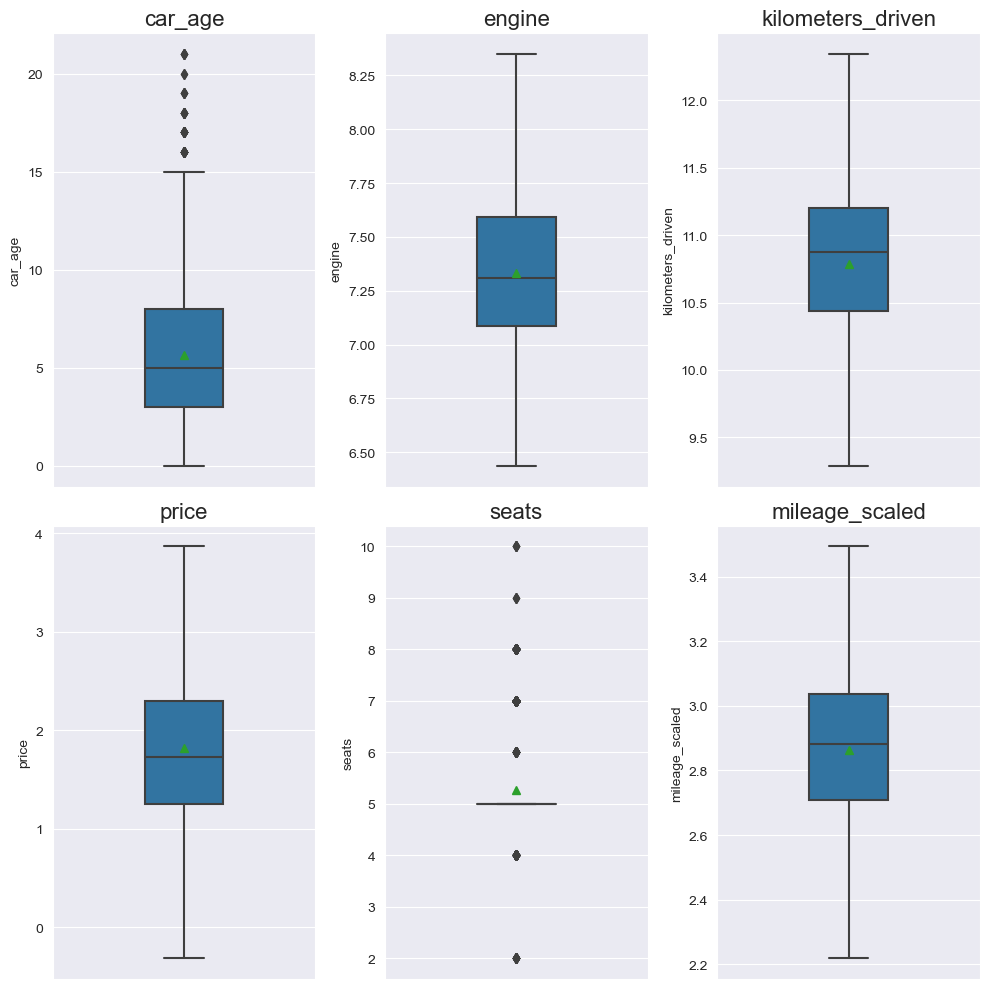

In [13]:
# Check the boxplot overview to see if any outliers still exist
boxplot_overview(df1)

There are no more outlier for continuous variables

**Encoding Categorical Variables**

In [14]:
# Get list of categorical values for onehot encoding
vars_req_encoding = df1.select_dtypes(exclude=np.number).columns.to_list()
vars_req_encoding

['fuel_type', 'owner_type', 'region', 'transmission', 'car_category']

**One hot encoding**

In [15]:
df1 = pd.get_dummies(df1, columns = vars_req_encoding, drop_first=True, dtype=float)
df1.head()

,car_age,engine,kilometers_driven,price,seats,mileage_scaled,fuel_type_Diesel,fuel_type_LPG,fuel_type_Petrol,owner_type_Fourth & Above,owner_type_Second,owner_type_Third,region_North,region_South,region_West,transmission_Manual,car_category_Luxury_Cars,car_category_Mid-Range,car_category_Ultra_Luxury
0,16,7.305860,11.289782,0.300105,5.0,2.526456,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,5,7.584773,11.280628,2.803360,5.0,3.000177,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2,7.584773,9.998798,3.113515,5.0,3.000177,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,7.584773,9.903638,2.957511,5.0,3.000177,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,3,7.584773,10.571317,2.939162,5.0,3.000177,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


---

# Model Building

**Separating Independent and Dependent variables**

In [16]:
# Separating Independent and Dependent variables**
# Independant variables
x = df1.drop(['price'], axis=1)
# Dependent variable
y = df1[['price']]

## Statsmodels Ordinary Least Squares (OLS)

**Prepare training and testing datasets**

In [17]:
# This adds the constant term beta0 to the Linear Regression.
# "sm.add_constant(x)" - adds a column of ones the shape of x
X_con = sm.add_constant(x)
X_train, X_test, Y_train, Y_test = train_test_split(X_con,
                                                    y,
                                                    test_size=0.30,
                                                    random_state=1)

**Train, Test set details**

In [18]:
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in train data =", X_test.shape[0])

Number of rows in train data = 4211
Number of rows in train data = 1805


**Make the linear model using OLS**

In [19]:
ols_model = sm.OLS(Y_train, X_train).fit()
# OLS Summary
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     2268.
Date:                Wed, 01 Nov 2023   Prob (F-statistic):               0.00
Time:                        22:50:08   Log-Likelihood:                -360.16
No. Observations:                4211   AIC:                             758.3
Df Residuals:                    4192   BIC:                             878.9
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -5.6421      0.288    -19.611      0.000      -6.206      -5.078
car_age                      -0.0937      0.002    -52.134      0.000      -0.097      -0.090
engine                        1.1068      0.027     41.759      0.000       1.055       1.159
kilometers_driven            -0.0678      0.009     -7.620      0.000      -0.085      -0.050
seats                        -0.0316      0.006     -4.931      0.000      -0.044      -0.019
mileage_scaled                0.1561      0.034      4.613      0.000       0.090       0.222
fuel_type_Diesel              0.1644      0.043      3.787      0.000       0.079       0.249
fuel_type_LPG                 0.0774      0.109      0.711      0.477      -0.136       0.291
fuel_type_Petrol              0.0848      0.044      1.942      0.052      -0.001       0.170
owner_type_Fourth & Above     0.0331      0.119      0.278      0.781      -0.200       0.266
owner_type_Second            -0.0601      0.012     -5.065      0.000      -0.083      -0.037
owner_type_Third             -0.1726      0.032     -5.454      0.000      -0.235      -0.111
region_North                  0.1599      0.018      9.134      0.000       0.126       0.194
region_South                  0.2576      0.015     16.643      0.000       0.227       0.288
region_West                   0.1830      0.016     11.377      0.000       0.151       0.215
transmission_Manual          -0.2211      0.012    -17.831      0.000      -0.245      -0.197
car_category_Luxury_Cars      0.9140      0.020     46.235      0.000       0.875       0.953
car_category_Mid-Range        0.4926      0.016     31.717      0.000       0.462       0.523
car_category_Ultra_Luxury     1.0118      0.038     26.973      0.000       0.938       1.085
==============================================================================
Omnibus:                      558.384   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2001.237
Skew:                          -0.642   Prob(JB):                         0.00
Kurtosis:                       6.123   Cond. No.                     1.11e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
# Predictions on the training set
# X_train represents the feature variables for the training set
y_train_pred = ols_model.predict(X_train)

# Predictions on the test set
# X_test represents the feature variables for the test set
y_test_pred = ols_model.predict(X_test)

# Calculate RMSE, MAE, and MAPE for the training set
train_rmse = np.sqrt(mean_squared_error(Y_train, y_train_pred))
train_mae = mean_absolute_error(Y_train, y_train_pred)

# Calculate RMSE, MAE, and MAPE for the test set
test_rmse = np.sqrt(mean_squared_error(Y_test, y_test_pred))
test_mae = mean_absolute_error(Y_test, y_test_pred)

# Print the results
print("Train RMSE:", round(train_rmse, 3))
print("Test RMSE:", round(test_rmse, 3))
print("Train MAE:", round(train_mae, 3))
print("Test MAE:", round(test_mae, 3))

Train RMSE: 0.264
Test RMSE: 0.257
Train MAE: 0.199
Test MAE: 0.196


---

**Interpreting the Regression Results:**

1. **Adjusted. R-squared**: It reflects the fit of the model.
    - R-squared values range from 0 to 1, where a higher value generally indicates a better fit, assuming certain conditions are met.
    - In our case, the value for Adj. R-squared is **0.907**, which is  a very good!
2. **const coefficient** is the Y-intercept.
    - It means that if all the dependent variables (features: like car_age, engine and so on..) coefficients are zero, then the expected output (i.e., the Y) would be equal to the const coefficient.
    - In our case, the value for const coeff is **-5.6421**

3. **power coef**: It represents the change in the output Y due to a change of one unit in the power (while everything else held constant).
4. **std err**: It reflects the level of accuracy of the coefficients.
    - The lower it is, the higher is the level of accuracy.
5. **P >|t|**: It is p-value.
   
   * Pr(>|t|) : For each independent feature there is a null hypothesis and alternate hypothesis  

    Ho : Independent feature is not significant 

    Ha : Independent feature is that it is significant
    
    Pr(>|t|) gives P-value for each independent feature to check that null hypothesis. we are considering 0.05 (5%) as significance level
    * A p-value of less than 0.05 is considered to be statistically significant.

    **From above we can clearly see:**
    * All the numerical variables have p-values smaller that 0.0001, therefore they are all features are statistically significant.
    * There are many categorical elements with p-values >0.05
   
6. **Confidence Interval**: It represents the range in which our coefficients are likely to fall (with a likelihood of 95%).

---

**Visualizing OLS prediction**

**Price: Actuals vs Predictions**

Lets visualize the plot of the price Prediction to the Actual Values

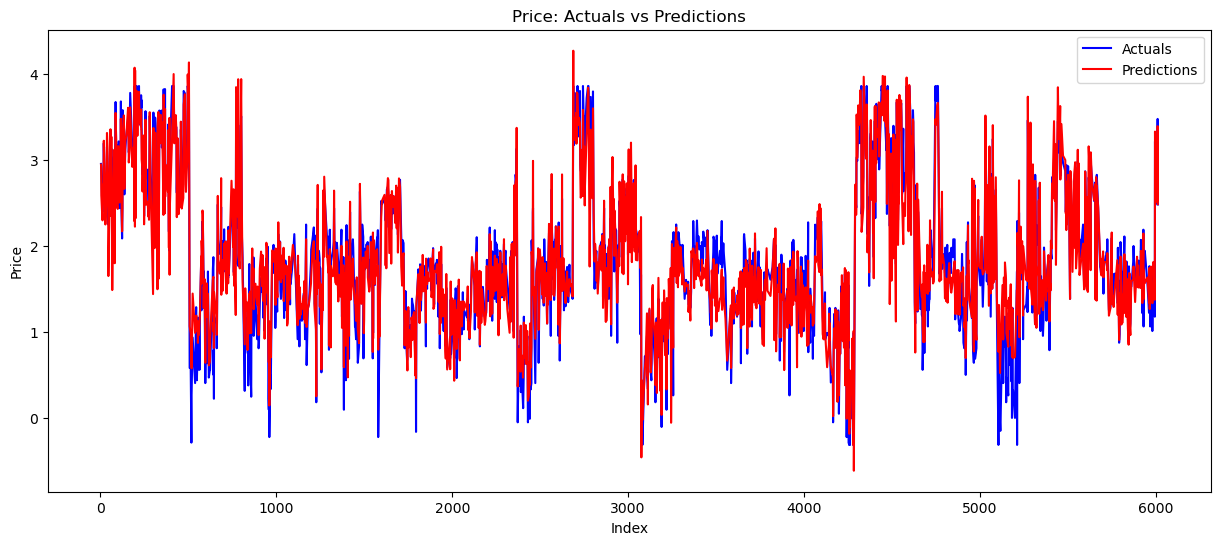

In [21]:
# Generate subplot
fig, ax = plt.subplots(figsize=(15, 6))
# Plot Actual Price values
sns.lineplot(x=Y_test.index,
             y=Y_test.price,
             label='Actuals',
             color='blue',
             ax=ax)
# Plot Price Prediction values
sns.lineplot(x=Y_test.index, 
             y=y_test_pred, 
             label='Predictions', 
             color='red', 
             ax=ax)
# Configure axes titles
ax.set_title('Price: Actuals vs Predictions')
ax.set_ylabel('Price')
ax.set_xlabel('Index')
plt.show()

**Observations:**
* The predictions appear to be tracking the actual values. This is indicated by the high Adjusted R2 value of 0.907

---

## Testing Linear Regression Assumptions

Although we have identified that:
* There does not exist a strong linear relationship between Residuals and Predictions, 
* There is indication of *Heteroscedasticity*
* The residuals follow a normal distribution.

Lets test the Linear Regression Assumptions.
1. No Multicollinearity
2. Mean of residuals should be 0
3. No Heteroscedacity
4. Linearity of variables
5. Normality of error terms

**Testing for Multicollinearity using VIF scores**

Test for Multicollinearity

* Multicollinearity occurs when predictor variables in a regression model are correlated. This correlation is a problem because predictor variables should be independent.  If the correlation between variables is high, it can cause problems when we fit the model and interpret the results. When we have multicollinearity the linear model, The coefficients that the model suggests are unreliable.  


* There are different ways of detecting(or  testing) multi-collinearity, one such way is the **Variance  Inflation  factor**:      
    * Variance  inflation  factors  measure  the  inflation  in  the variances of the regression parameter estimates due to collinearities that exist among the  predictors.  It  is  a  measure  of  how  much  the  variance  of  the  estimated  regression coefficient β̂k is *inflated* by  the  existence  of  correlation  among  the  predictor variables in the model. 


* General Rule of thumb: 
    * If VIF is 1 then there is no correlation among the kth predictor and the remaining predictor variables, and  hence  the variance of β̂k is not inflated at all.
    * if VIF exceeds 5 or is close to exceeding 5, we say there is moderate VIF and if it is 10 or exceeding 10, it shows signs of high multi-collinearity.

Lets check the VIF scores for the OLS training dataset **X_train**

**Import variance_inflation_factor from statsmodels**

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [23]:
# create an empty dataframe
vif = pd.DataFrame()
# add "variables" series from the columns of X_train
vif['variables'] = X_train.columns
# calculate the VIF values for all elements from second row
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
# display vif dataframe
vif

,variables,VIF
0,const,4994.406990
1,car_age,2.098426
2,engine,4.838670
3,kilometers_driven,1.849490
4,seats,1.607249
5,mileage_scaled,3.880893
6,fuel_type_Diesel,28.305081
7,fuel_type_LPG,1.189574
8,fuel_type_Petrol,28.574623
9,owner_type_Fourth & Above,1.014438


**Observations:**

`fuel_type` variables are showing high vif because most cars are either diesel and petrol. These two features are correlated with each other.

We will not drop this variable from the model because this will not affect the interpretation of other features in the model

---

**Mean of residuals**

In [24]:
model_residuals = ols_model.resid
print(f"The mean of the residuals are  '{round(model_residuals.mean())}'.")

The mean of the residuals are  '0'.


Mean of redisuals is very close to 0. The second assumption is also satisfied.

---

**Heteroscedasticity**

*Homoscedacity* - If the residuals are symmetrically distributed across the regression line , then the data is said to homoscedastic.

*Heteroscedasticity* - If the residuals are not symmetrically distributed across the regression line, then the data is said to be heteroscedastic. In this case the residuals can form a funnel shape or any other non symmetrical shape.

We'll use `Goldfeldquandt Test` to test the following hypothesis

<u>Null hypothesis</u> : Residuals are homoscedastic

<u>Alternate hypothesis</u> : Residuals have hetroscedasticity

alpha = 0.05 

In [25]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

test_methods = ["F statistic", "p-value"]
test_function = sms.het_goldfeldquandt(model_residuals, X_train)
lzip(test_methods, test_function)

[('F statistic', 0.988383789865863), ('p-value', 0.6051963170953663)]

Since p-value > 0.05 we <u>cannot reject</u> the Null Hypothesis that the residuals are **homoscedastic**. 

**Observed vs Predicted values**

Lets visualize the plot of the price Observed to the Predicted Values

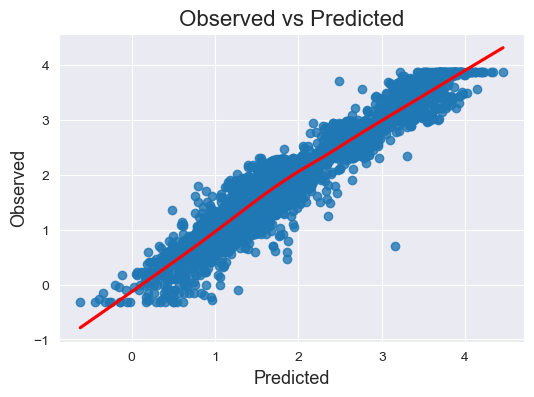

In [26]:
sns.set_style('darkgrid')
plt.figure(figsize=(6, 4))
sns.regplot(x=ols_model.predict(),
            y=Y_train,
            lowess=True,
            line_kws={'color': 'red'})
plt.title('Observed vs Predicted', fontsize=16)
plt.xlabel('Predicted', fontsize=13)
plt.ylabel('Observed', fontsize=13)
plt.show()

**Observations:**
* There does appear to be a strong linear relationship between the Residuals and the Prediction.
* The variance of the residuals changes significantly with Prediction. **Homoscedasticity** exists.

---

**Linearity of variables**

Predictor variables must have a linear relation with the dependent variable.

To test the assumption, we'll plot residuals and fitted values on a plot and ensure that residuals do not form a strong pattern. They should be randomly and uniformly scattered on the x axis.

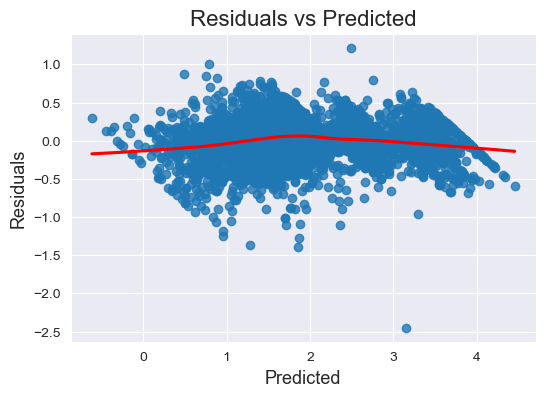

In [27]:
sns.set_style('darkgrid')
plt.figure(figsize=(6, 4))
sns.regplot(x=ols_model.predict(),
            y=ols_model.resid,
            lowess=True,
            line_kws={'color': 'red'})
plt.title('Residuals vs Predicted', fontsize=16)
plt.xlabel('Predicted', fontsize=13)
plt.ylabel('Residuals', fontsize=13)
plt.show()

**Observations:**
* There appears to be a linear relationship between the Residuals and the Prediction.
* The variance of the residuals relatively constant with Prediction. **Homoscedasticity** exists.
* There appears to be some outliers that may not have been dealt with.

---

**Normality of error terms**

The residuals should be normally distributed.

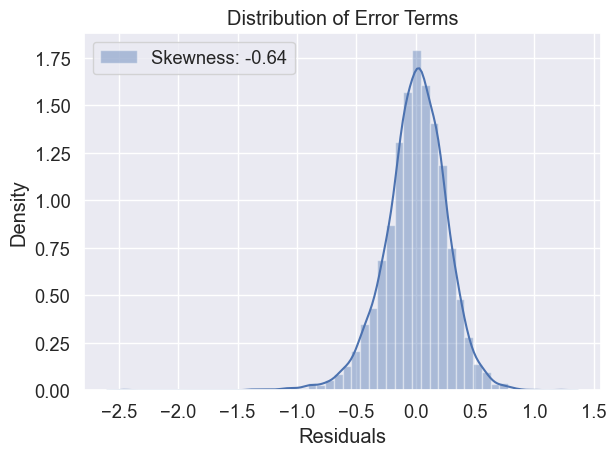

In [28]:
sns.set_style("darkgrid")
sns.set(font_scale = 1.2)
sns.distplot(ols_model.resid, label='Skewness: %.2f' %ols_model.resid.skew())
plt.title("Distribution of Error Terms")
plt.xlabel("Residuals")
plt.tight_layout()
plt.legend()
plt.show()

**Observations:**
* The residuals follow a normal distribution.

**Residuals QQ Plot**   

Lets visualize the Residuals QQ Plot.

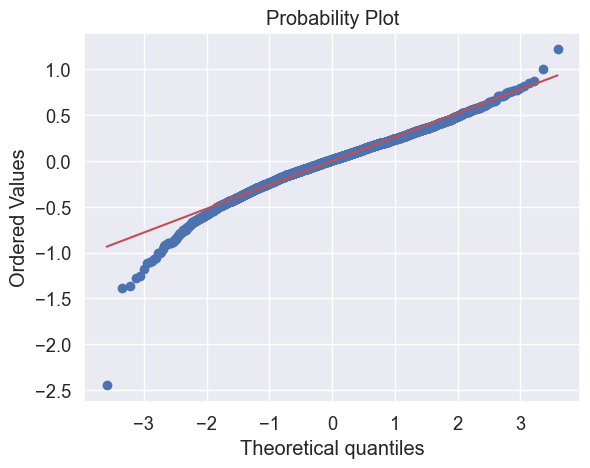

In [29]:
import scipy.stats as stats
import pylab
stats.probplot(ols_model.resid, dist='norm', plot=plt)
plt.show()

**Observations:**
* The residuals follow a normal distribution for most of the data.

---

# Table of Regression Coefficients

In [30]:
# extract Regression Coeff from OLS model
coeff_table = ols_model.summary2().tables[1][["Coef."]]
# Rename columns name for ease of use
coeff_table = coeff_table.rename(columns={'Coef.': 'reg_coeff'})
# display regression coefficients
coeff_table

,reg_coeff
const,-5.642122
car_age,-0.093709
engine,1.106750
kilometers_driven,-0.067837
seats,-0.031594
mileage_scaled,0.156085
fuel_type_Diesel,0.164371
fuel_type_LPG,0.077447
fuel_type_Petrol,0.084822
owner_type_Fourth & Above,0.033057


**Top 10 largest regression coefficients**

In [31]:
coeff_table.reg_coeff.nlargest(10).to_frame()

,reg_coeff
engine,1.106750
car_category_Ultra_Luxury,1.011804
car_category_Luxury_Cars,0.914021
car_category_Mid-Range,0.492639
region_South,0.257587
region_West,0.183008
fuel_type_Diesel,0.164371
region_North,0.159899
mileage_scaled,0.156085
fuel_type_Petrol,0.084822


**Top 10 smallest regression coefficients**

In [32]:
coeff_table.reg_coeff.nsmallest(10).to_frame()

,reg_coeff
const,-5.642122
transmission_Manual,-0.221097
owner_type_Third,-0.172578
car_age,-0.093709
kilometers_driven,-0.067837
owner_type_Second,-0.060140
seats,-0.031594
owner_type_Fourth & Above,0.033057
fuel_type_LPG,0.077447
fuel_type_Petrol,0.084822


**Regression coefficients sorted in descending order**

In [33]:
coeff_table.sort_values(by="reg_coeff", ascending=False)

,reg_coeff
engine,1.106750
car_category_Ultra_Luxury,1.011804
car_category_Luxury_Cars,0.914021
car_category_Mid-Range,0.492639
region_South,0.257587
region_West,0.183008
fuel_type_Diesel,0.164371
region_North,0.159899
mileage_scaled,0.156085
fuel_type_Petrol,0.084822


---

**Regression coefficients and unit price increase sorted in descending order**

In [34]:
coeff_table['unit_price_increase (Lakh)'] = round(np.exp(coeff_table['reg_coeff'] ), 3)
coeff_table.sort_values(by="reg_coeff", ascending=False)

,reg_coeff,unit_price_increase (Lakh)
engine,1.106750,3.025
car_category_Ultra_Luxury,1.011804,2.751
car_category_Luxury_Cars,0.914021,2.494
car_category_Mid-Range,0.492639,1.637
region_South,0.257587,1.294
region_West,0.183008,1.201
fuel_type_Diesel,0.164371,1.179
region_North,0.159899,1.173
mileage_scaled,0.156085,1.169
fuel_type_Petrol,0.084822,1.089


# Model Observations

With our linear regression model we have been able to capture ~90 variation in our data.

The model indicates that the most significant predictors of price of used cars are:
- Engine size
- Car category
- Region
- Fuel type
- Mileage

# Business Recommendations

**Engine Size:** Consider offering a range of engine sizes to cater to different customer preferences. Smaller engines are typically more fuel-efficient, so emphasize their benefits for cost-conscious buyers. For those looking for more power, highlight the advantages of larger engines in terms of performance.
<br>

**Car Category:** Focus on popular car categories in your region. If compact cars are in demand, ensure you have a diverse selection of models in that category. Promote the benefits of each category, such as fuel efficiency for compact cars and spaciousness for SUVs.
<br>

**Region:** Tailor your inventory and marketing to match regional preferences. For example, if SUVs are popular in suburban areas, stock a variety of SUV models and emphasize their suitability for family and outdoor activities.
<br>

**Fuel Type:** Offer cars with different fuel types, including gasoline, diesel, and hybrid options. Highlight the cost savings and environmental benefits of fuel-efficient and hybrid vehicles, especially in regions where eco-friendliness is a priority.
<br>

**Mileage:** Clearly communicate the mileage and maintenance history of each vehicle. Lower mileage vehicles can be priced higher, so ensure prospective buyers have access to this information. Offer special promotions or warranties for low-mileage cars.

---